In [1]:
import sys
sys.path.append("../../src/earthtext")

from osm import osm
import os
from progressbar import progressbar as pbar
import shapely as sh 
from pyproj import CRS
import numpy as np
epsg4326 = CRS.from_epsg(4326)
import geopandas as gpd
import pandas as pd
from importlib import reload
from rlxutils import Command, subplots
from time import time
import folium
import matplotlib.pyplot as plt
from joblib import delayed
reload(osm)

<module 'osm.osm' from '/home/ubuntu/earth-text/notebooks/osm/../../src/earthtext/osm/osm.py'>

## generate osb object stats for all chips

In [2]:
dgd = gpd.read_parquet('/opt/data/california-worldcover-chips-osm.parquet')

In [3]:
def get_stats(chip_id):

    z = gpd.read_parquet(f"/opt/data/california-worldcover-chips/osm/{chip_id}.parquet")
    z['tags'] = [eval(i) if isinstance(i, str) else i for i in z.tags]
    z['tags'] = [osm.clean_tags(t) for t in z.tags]
    z = z[[len(t)>0 for t in z['tags']]]
    if len(z)==0:
        return None, None
    
    keys, keyvals = [], []
    for _, r in z.iterrows():
        for k,v in r.tags.items():
            keys.append({'key': k, 'length':r.length, 'area': r.area, 'count': 1, r['kind']: 1})
            keyvals.append({'keyval': f"{k}={v}", 'length':r.length, 'area': r.area, r['kind']: 1, 'count': 1})
    keys = pd.DataFrame(keys).groupby('key').sum()
    keyvals = pd.DataFrame(keyvals).groupby('keyval').sum()
    keys['n_chips'] = 1
    keyvals['n_chips'] = 1
    return keys, keyvals



In [4]:
r = osm.mParallel(n_jobs=30, verbose=30)(delayed(get_stats)(chip_id) for chip_id in dgd.chip_id.values)
r = [i for i in r if i[0] is not None]
len(r)

 [mParallel(n_jobs=30)]: Done 92440 out of 92440 | elapsed:  4.2min finishedg:    0.2sch_size=4..

86828

In [5]:
s = {'keys': [i[0] for i in r],
     'keyvalues': [i[1] for i in r]
    }


## aggregate stats of all chips in two dataframes

- one df for keys
- one df for key-values

In [6]:
def add_dataframes(dflist):
    if len(dflist)<5000:
        print (".", end="", flush=True)
        r = dflist[0]
        for df in dflist[1:]:
            r = r.add(df, fill_value=0)
        return r.fillna(0)
    else:
        n = len(dflist)
        add1 = add_dataframes(dflist[:n//2])
        add2 = add_dataframes(dflist[n//2:])
        return add1.add(add2, fill_value=0) 

In [7]:
allkstats = add_dataframes(s['keys'])

................................

In [8]:
allkvstats = add_dataframes(s['keyvalues'])

................................

In [16]:
allkstats['area_per_way'] = allkstats['area'] / allkstats['way']
allkvstats['area_per_way'] = allkvstats['area'] / allkvstats['way']

allkstats['length_per_way'] = allkstats['length'] / allkstats['way']
allkvstats['length_per_way'] = allkvstats['length'] / allkvstats['way']

In [17]:
allkstats.shape, allkvstats.shape

((3495, 8), (33278, 8))

In [18]:
allkstats.head()

,area,count,length,n_chips,node,way,area_per_way,length_per_way
key,,,,,,,,
3d_printing,9478.543858,3.0,462.417412,3.0,2.0,1.0,9478.543858,462.417412
_park_area_,1190.407947,19.0,586.452458,2.0,0.0,19.0,62.653050,30.865919
_street_,779.540745,11.0,345.988305,2.0,0.0,11.0,70.867340,31.453482
_yose_trl__,0.000000,9.0,14005.873752,9.0,0.0,9.0,0.000000,1556.208195
_yose_trl_i_,0.000000,9.0,14005.873752,9.0,0.0,9.0,0.000000,1556.208195


## visualize stuff

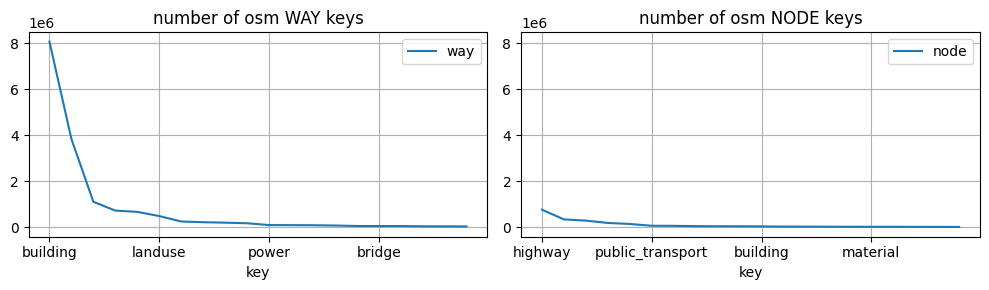

In [13]:
for ax,i in subplots(2, usizex=5):
    if i == 0:
        allkstats.sort_values('way', ascending=False).head(20)[['way']].plot(ax=ax)
        plt.grid()
        plt.title("number of osm WAY keys")
    if i == 1:
        allkstats.sort_values('node', ascending=False).head(20)[['node']].plot(ax=ax)
        plt.grid()
        plt.title("number of osm NODE keys")

    plt.ylim(0 - allkstats['way'].max()*0.05,allkstats['way'].max()*1.05)

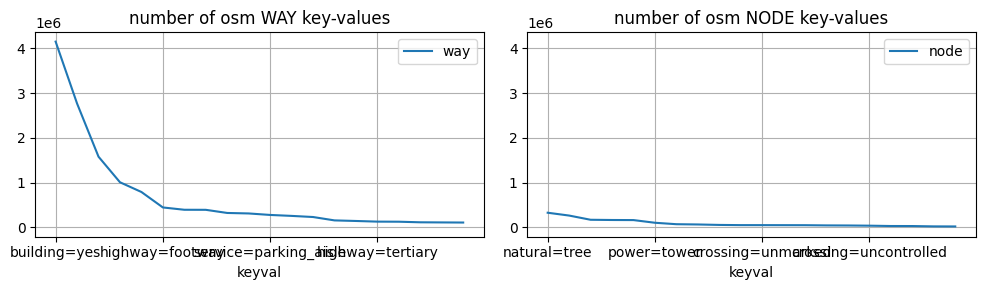

In [14]:
for ax,i in subplots(2, usizex=5):
    if i == 0:
        allkvstats.sort_values('way', ascending=False).head(20)[['way']].plot(ax=ax)
        plt.grid()
        plt.title("number of osm WAY key-values")
    if i == 1:
        allkvstats.sort_values('node', ascending=False).head(20)[['node']].plot(ax=ax)
        plt.grid()
        plt.title("number of osm NODE key-values")

    plt.ylim(0 - allkvstats['way'].max()*0.05,allkvstats['way'].max()*1.05)

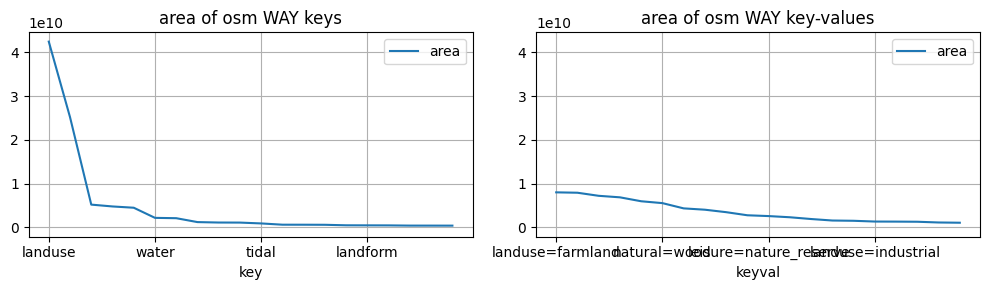

In [15]:
for ax,i in subplots(2, usizex=5):
    
    if i==0:
        allkstats.sort_values('area', ascending=False).head(20)[['area']].plot(ax=ax)
        plt.grid()
        plt.title("area of osm WAY keys")
    if i==1:
        allkvstats.sort_values('area', ascending=False).head(20)[['area']].plot(ax=ax)
        plt.grid()
        plt.title("area of osm WAY key-values")
        
    plt.ylim(0 - allkstats['area'].max()*0.05,allkstats['area'].max()*1.05)

## top 100 keys with most number of osm objects `way`

In [16]:
n=100

Text(0.5, 1.0, 'top 100 osm WAYS keys by count in log scale')

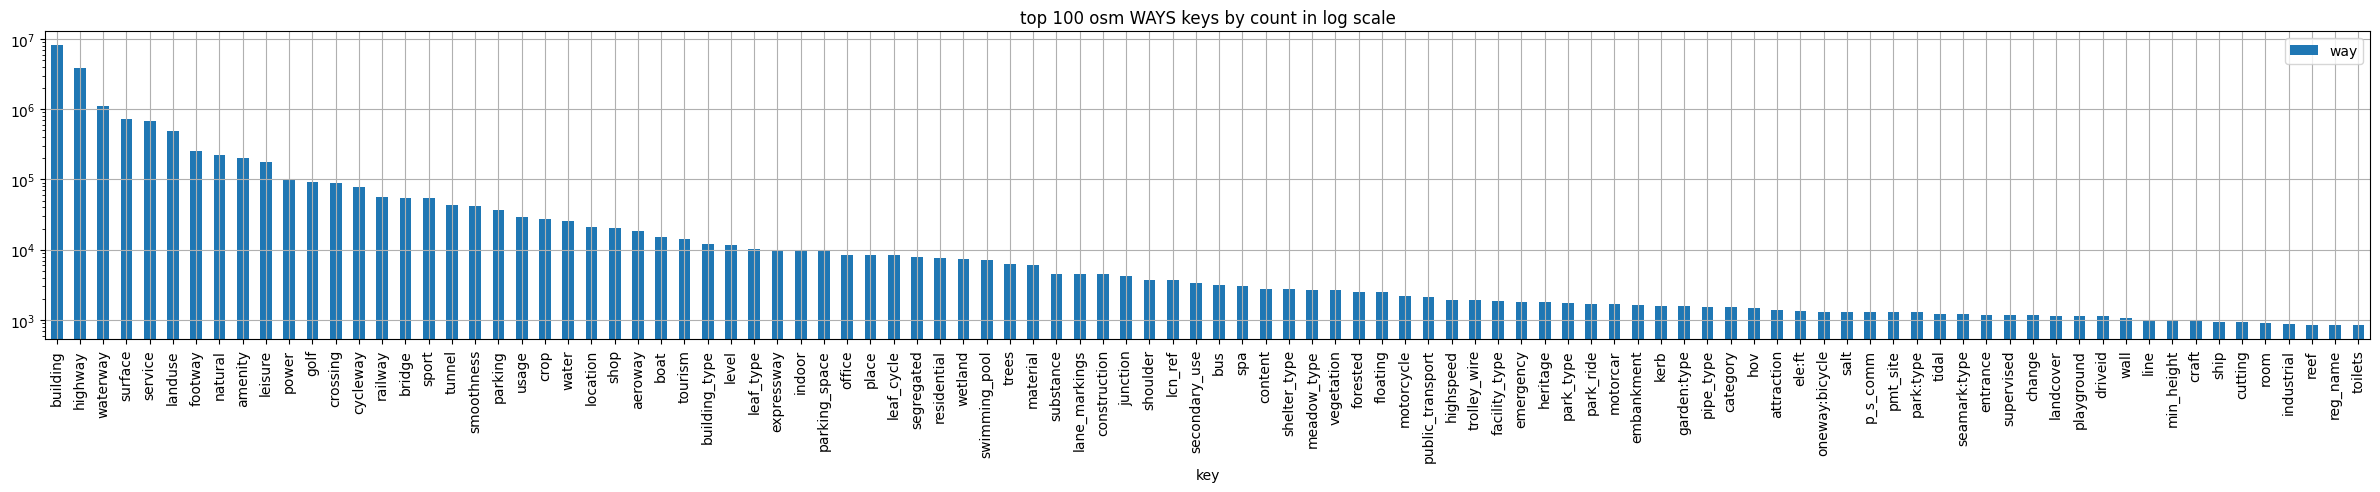

In [19]:
allk_top100 = allkstats.sort_values('way', ascending=False).iloc[:100]
allk_top100[['way']].plot(kind='bar', figsize=(30,4))
plt.grid()
plt.yscale('log')
plt.title("top 100 osm WAYS keys by count in log scale")

## details of values of the top 20 keys with most number of osm objects `way`

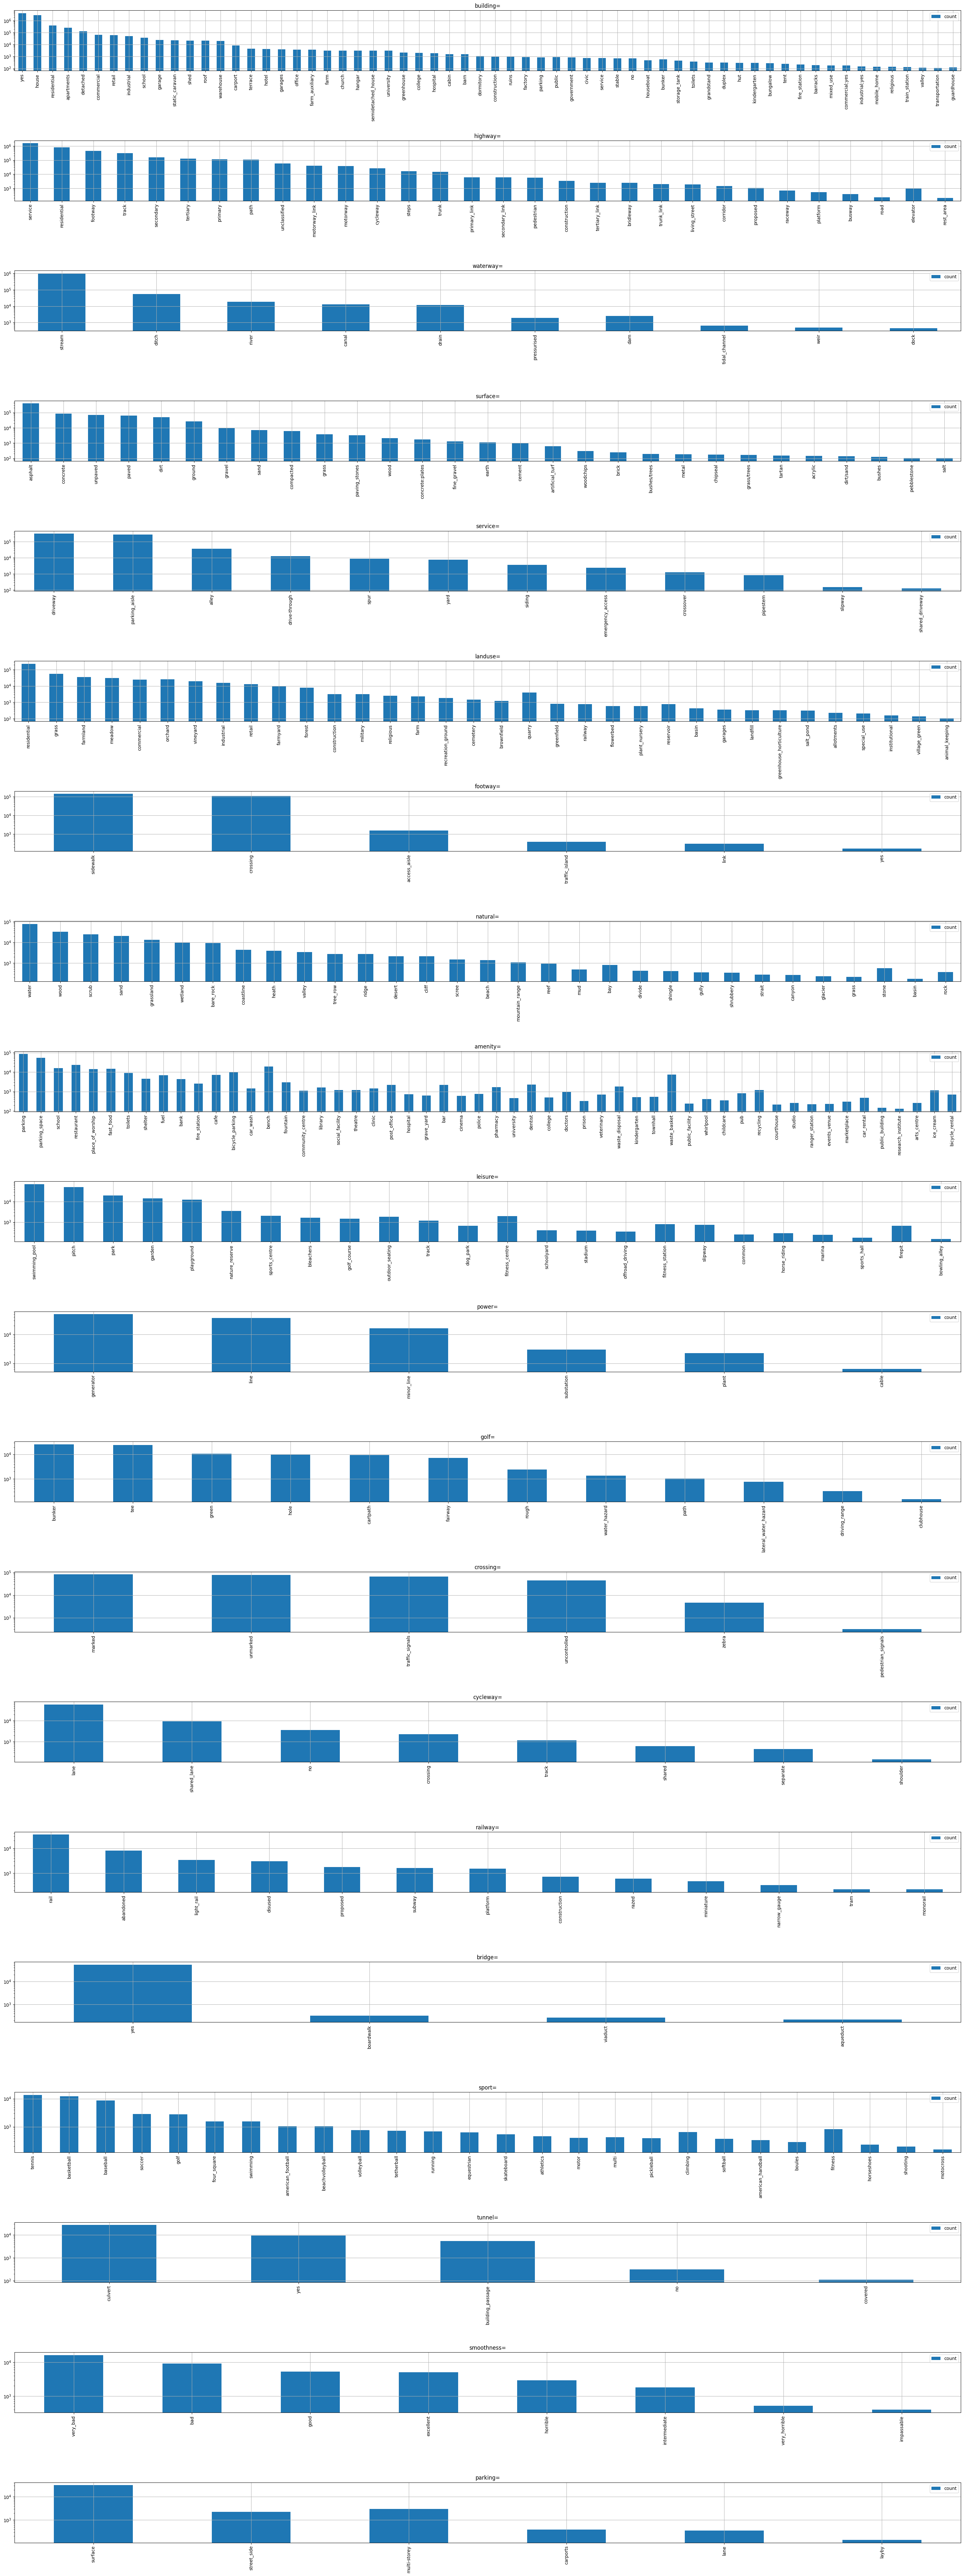

In [79]:
for ax, i in subplots(20, n_cols=1, usizex=30, usizey=4):
    
    key = allk_top100.index[i]+"="
    kstats = allkvstats[[i.startswith(key) for i in allkvstats.index]]
    kstats = kstats[kstats['way']>100].sort_values(by='way', ascending=False)
    kstats.index = [i[len(key):] for i in kstats.index]
    kstats[['count']].plot(kind='bar', ax=ax)
    plt.grid()
    plt.title(key)
    plt.yscale("log")
    

## top 100 osm CLOSED way objects by occurrence: mean object area vs count

showing the 20 most frequent values per key

closed objects have an area > 0

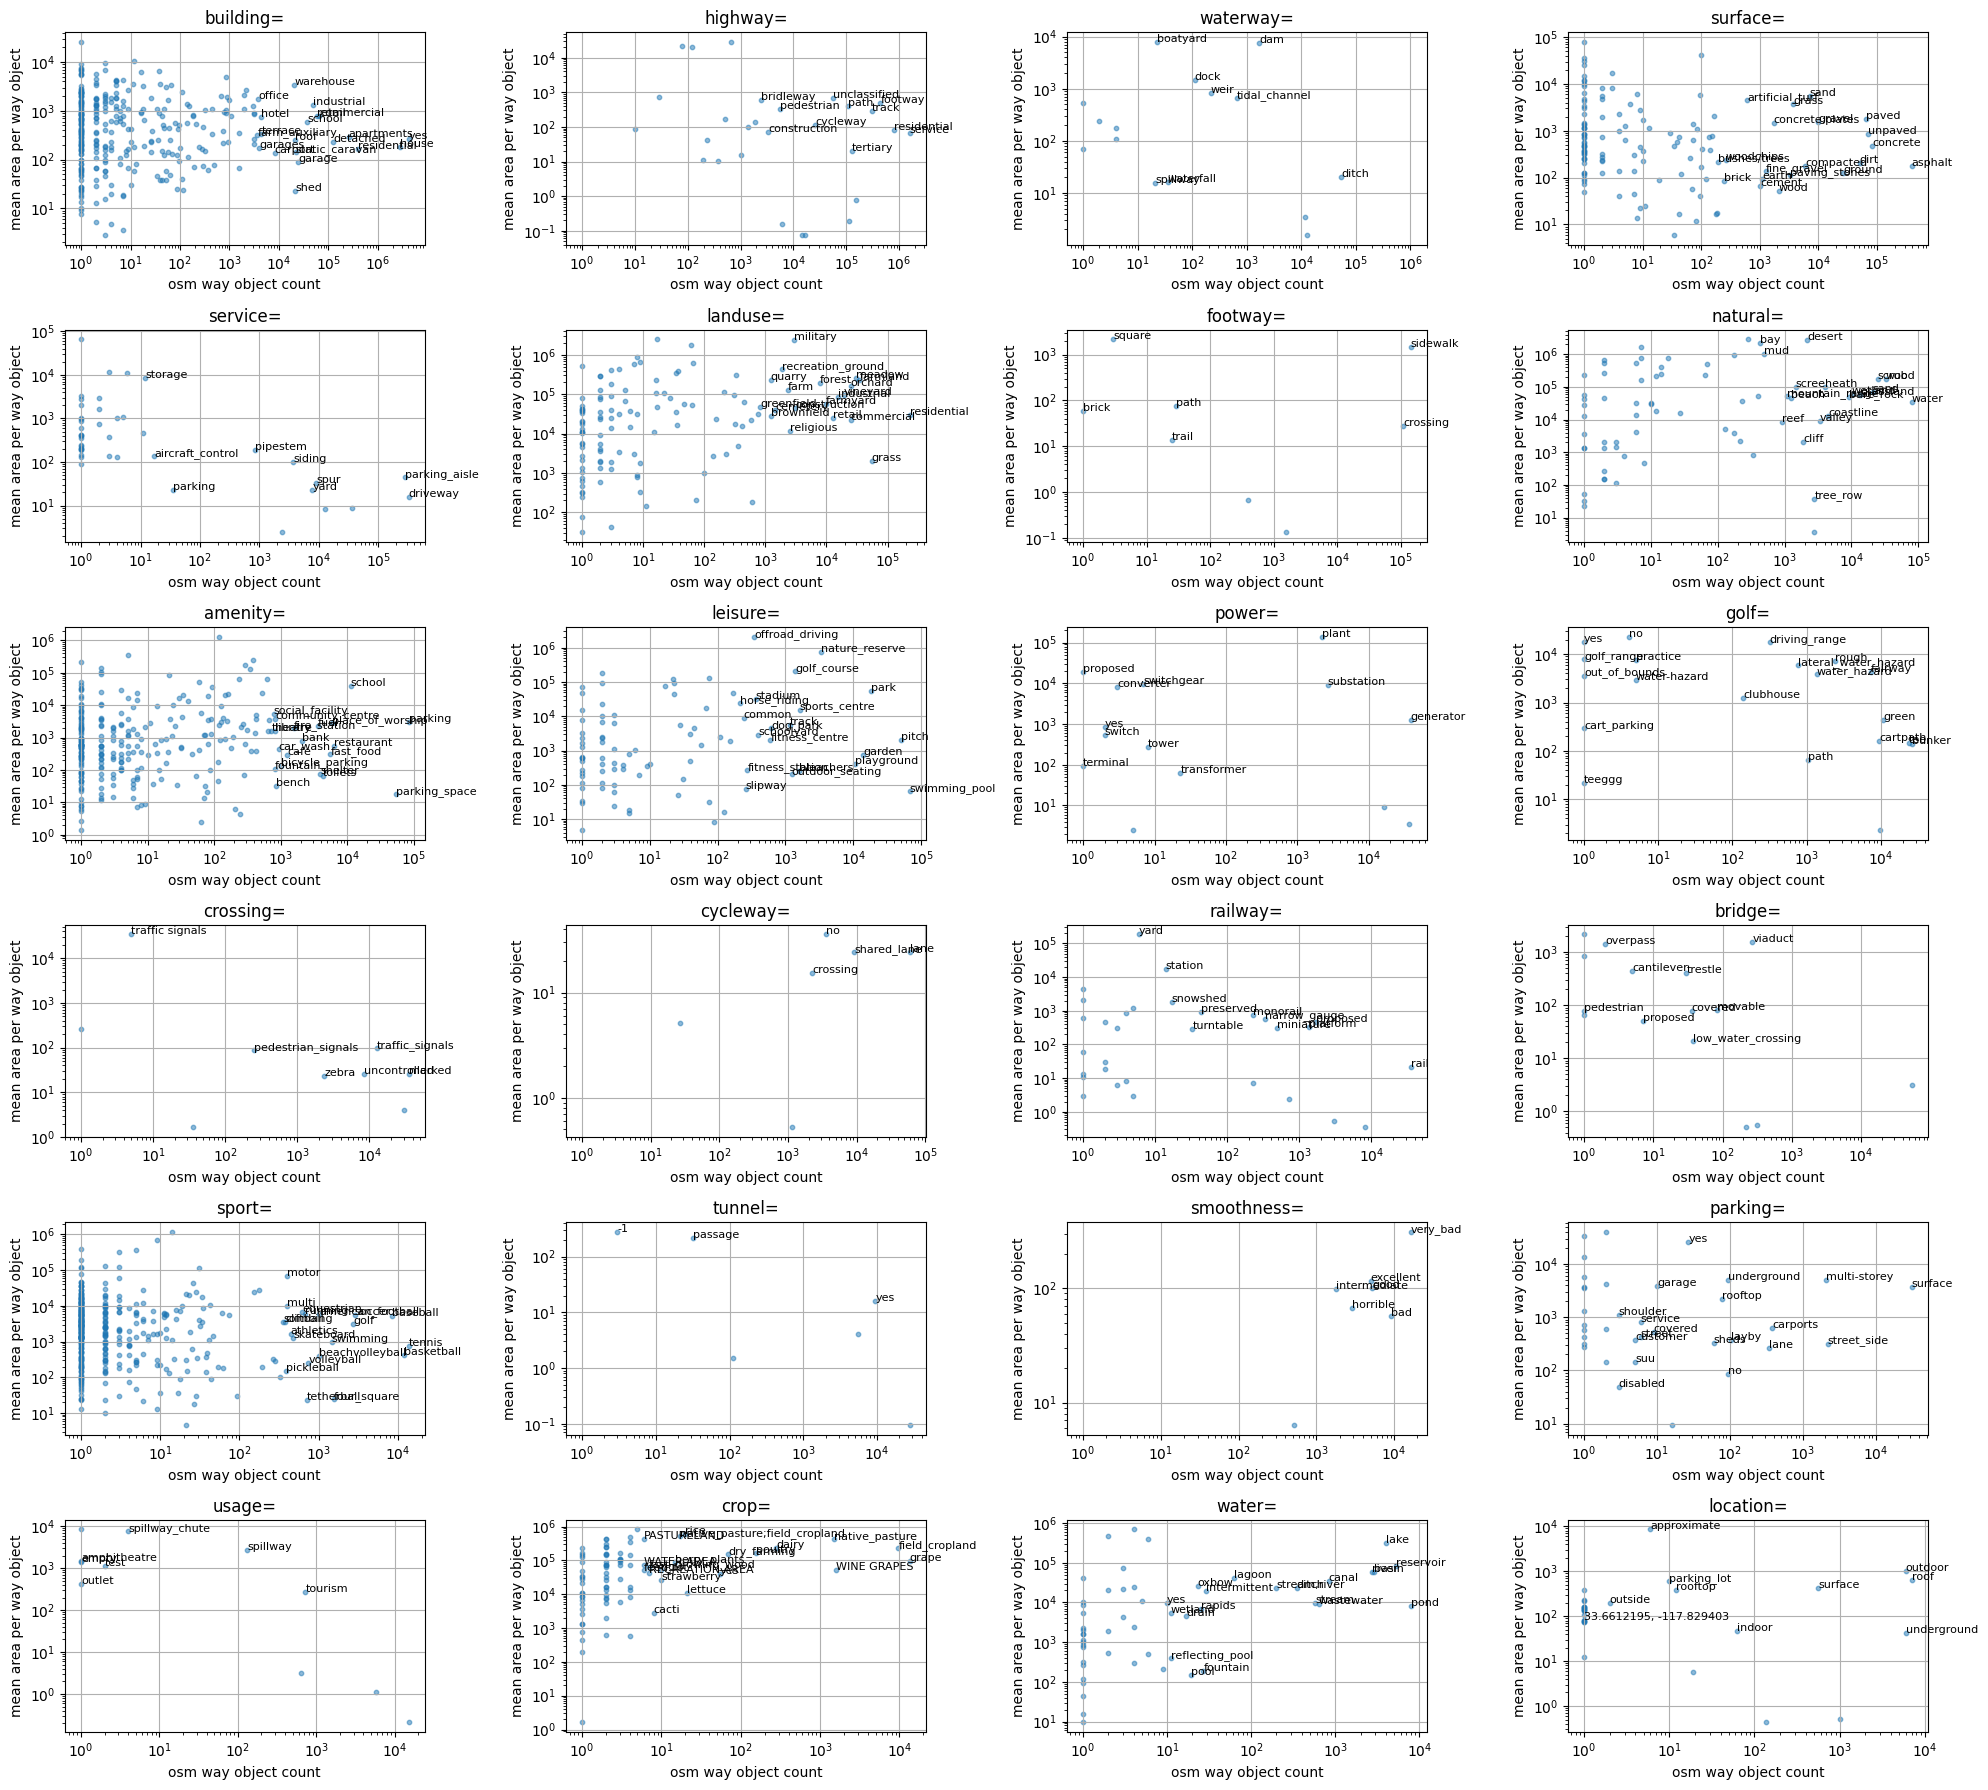

In [49]:
for ax,i in subplots(24, n_cols=4, usizex=5):
    key = allk_top100.index[i]+"="
    kstats = allkvstats[[i.startswith(key) for i in allkvstats.index]].sort_values('way', ascending=False)
    kstats = kstats[kstats['way']>0]
    kstats.index = [i[len(key):] for i in kstats.index]
    plt.scatter(kstats['way'], kstats['area_per_way'],s=10, alpha=.5)
    plt.grid();
    plt.xlabel("osm way object count")
    plt.ylabel("mean area per way object")
    #z = kstats[kstats['way']>200]
    z = kstats.iloc[:20]
    for _, zi in z.iterrows(): 
        if zi['area']<1e-3 or zi['area_per_way']<10:
            continue
        plt.text(zi['way'], zi['area_per_way'], zi.name, fontsize=8);
    plt.title(key)
    plt.yscale('log')
    plt.xscale('log')


## top 100 osm OPEN way objects by occurrence: mean object area vs count

showing the 20 most frequent values per key

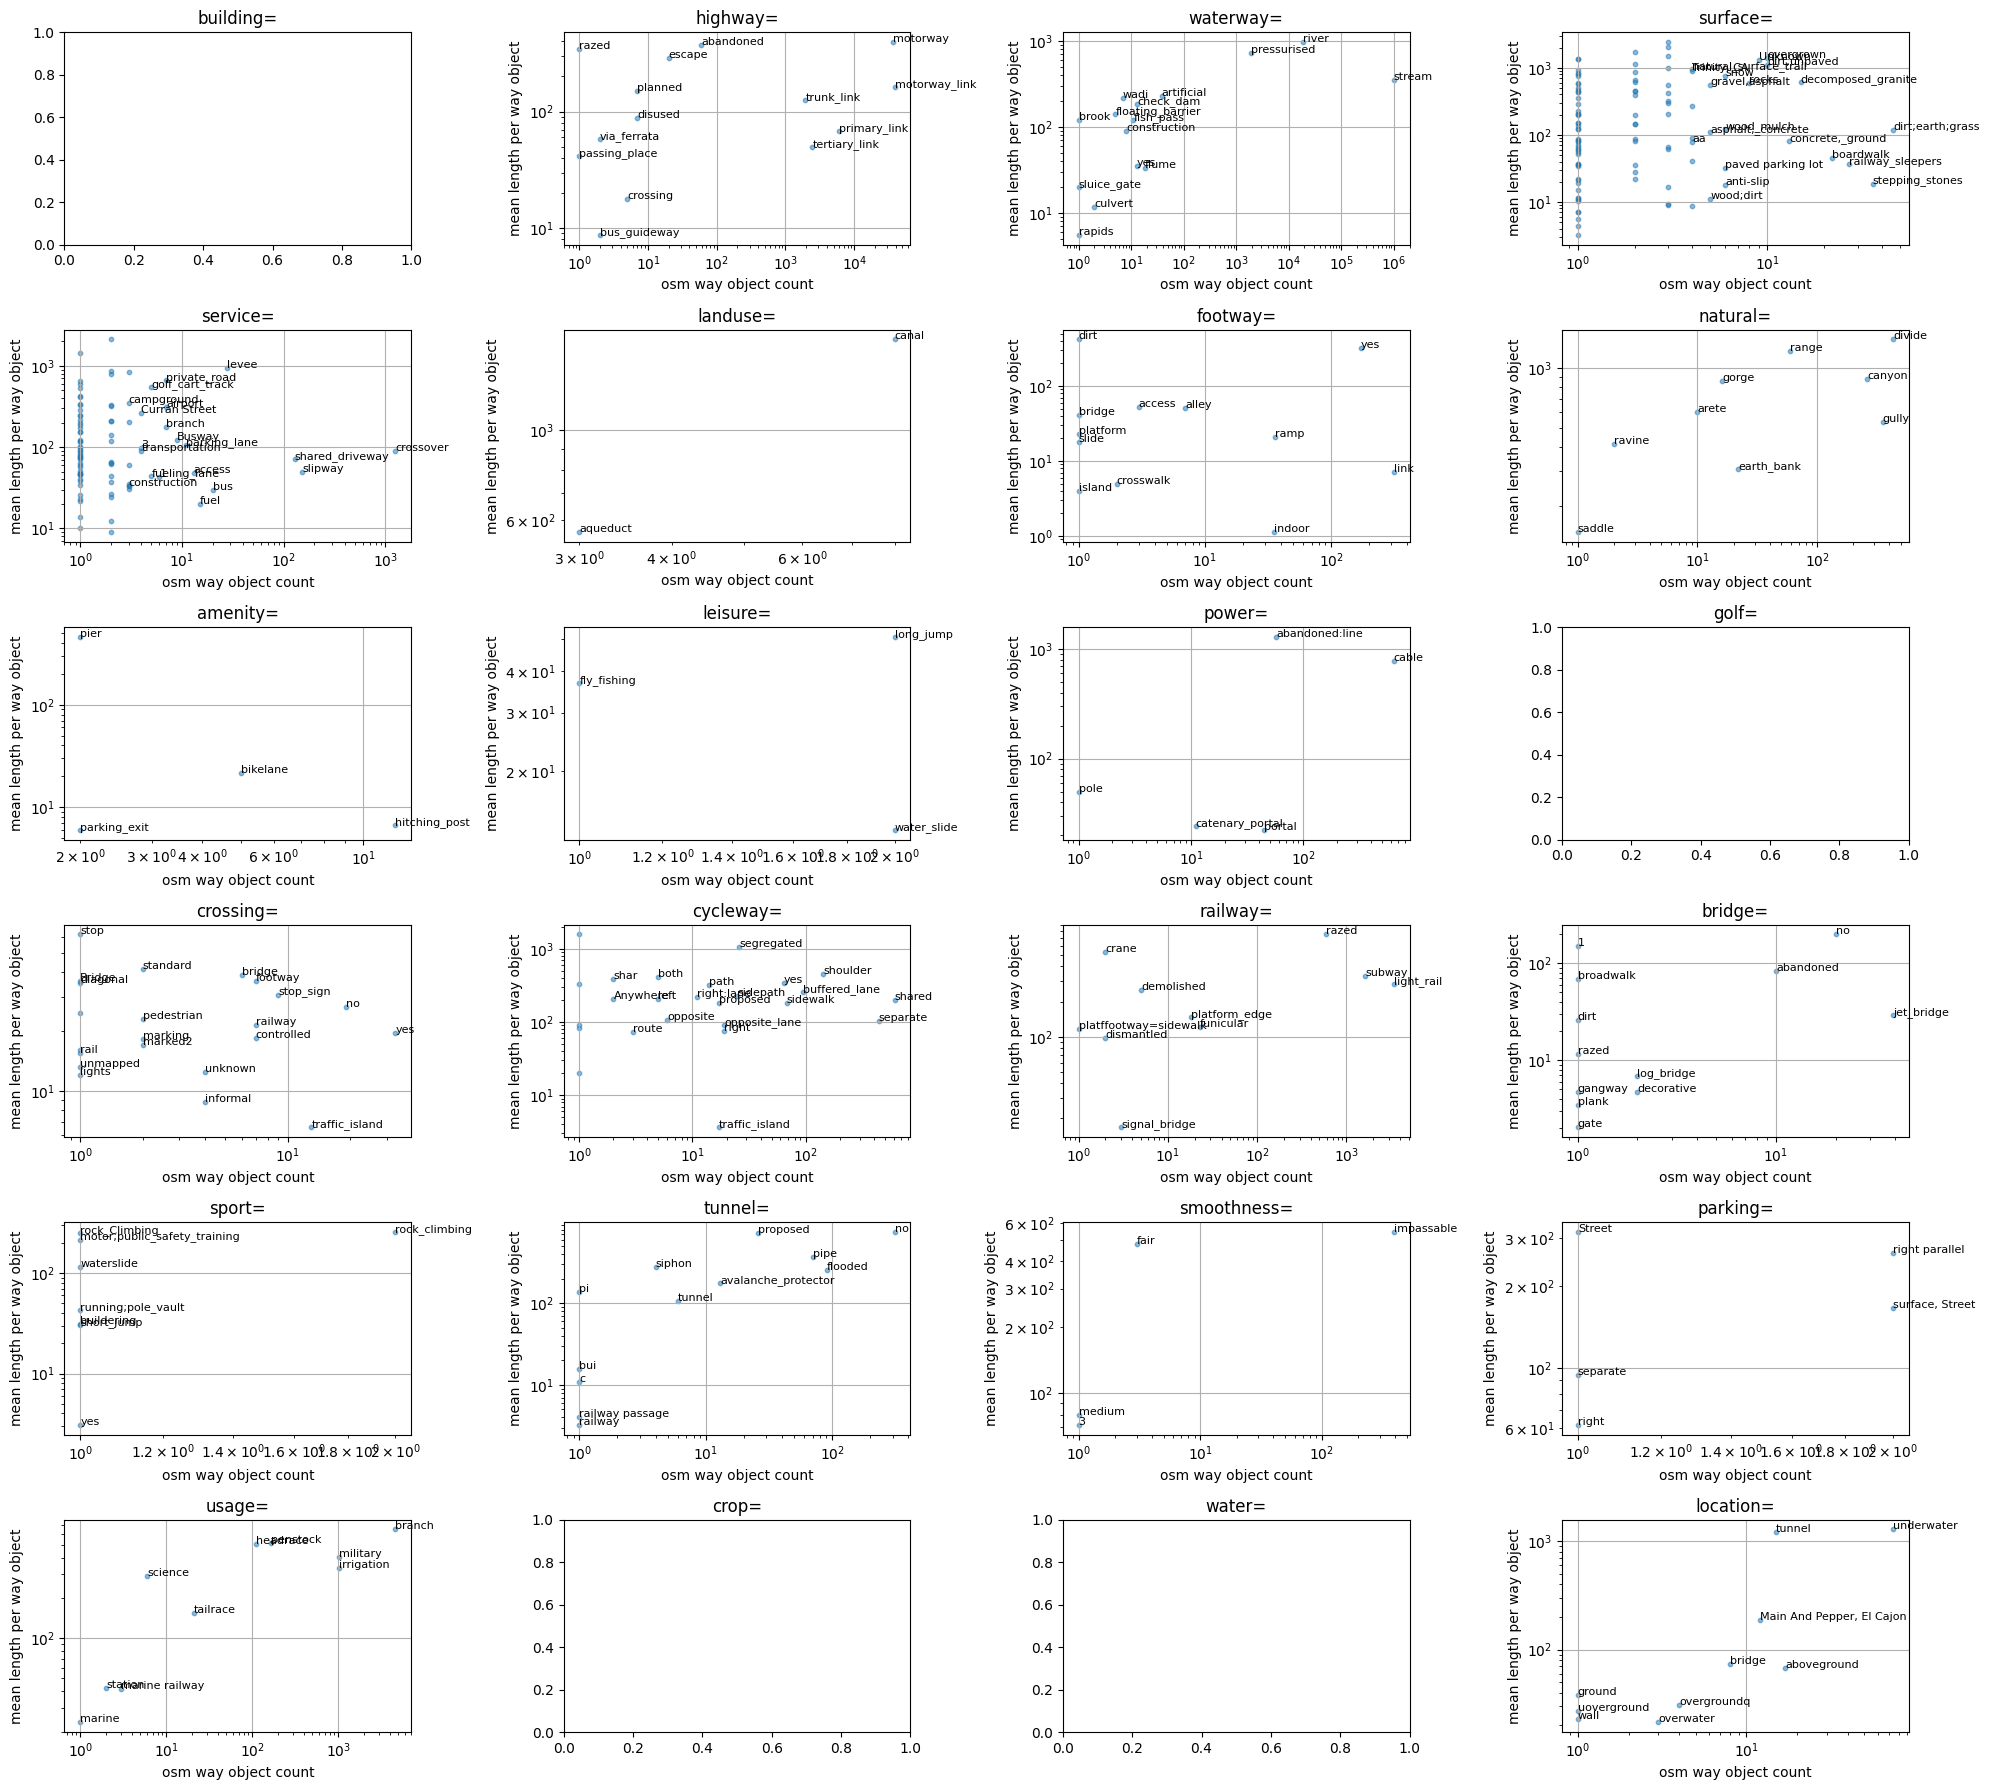

In [48]:
for ax,i in subplots(24, n_cols=4, usizex=5):
    key = allk_top100.index[i]+"="
    kstats = allkvstats[[i.startswith(key) for i in allkvstats.index]].sort_values('way', ascending=False)
    kstats.index = [i[len(key):] for i in kstats.index]
    kstats = kstats[(kstats['length']>0) & (kstats['area']==0)]
    plt.title(key)
    if len(kstats)==0:
        continue
    plt.scatter(kstats['way'], kstats['length_per_way'],s=10, alpha=.5)
    plt.grid();
    plt.xlabel("osm way object count")
    plt.ylabel("mean length per way object")
    #z = kstats[kstats['way']>200]
    z = kstats.iloc[:20]
    for _, zi in z.iterrows(): 
        plt.text(zi['way'], zi['length_per_way'], zi.name, fontsize=8);
    plt.yscale('log')
    plt.xscale('log')
